# MAIN

**NB this file simply includes the content of `feature_engineering.ipynb`, `logistic_regression.ipynb`, and `neural_network.ipynb` in that order.**

To run this document in Google Colab, please upload `ebnerd_small.zip` and `small_train_users_df_expanded.parquet` to the available Files for this document.

To run this document locally, please see the instructions in `README.md`.

# FEATURE_ENGINEERING

## DOCUMENT PREAMBLE

In [ ]:
# Import and set up libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import itertools
from tqdm import tqdm
import os

# Additional configurations
tqdm.pandas()
plt.style.use("classic")
#plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.family"] = "serif"

In [ ]:
# Set document parameters
data_version = "small"
data_type = "train"
include_plots = False

## LOAD AND SUMMARISE DATA

In [ ]:
# Load data from parquet files
def load_data(data_version, data_type, print_info=False):
    if data_type not in ["train", "validation"]:
        raise ValueError("data_type must be either 'train' or 'validation'")

    # Read parquet files into DataFrames
    behaviors_df = pd.read_parquet(
        f"./data/ebnerd_{data_version}/{data_type}/behaviors.parquet"
    )
    history_df = pd.read_parquet(f"./data/ebnerd_{data_version}/{data_type}/history.parquet")
    articles_df = pd.read_parquet(f"./data/ebnerd_{data_version}/articles.parquet")

    # Print DataFrame info
    if print_info:
        for name, df in zip(
            [f"{data_type}/behaviors", f"{data_type}/history", "articles"],
            [behaviors_df, history_df, articles_df],
        ):
            print(f"--- '{name}' ---\n")
            print(df.info(), "\n")

    return behaviors_df, history_df, articles_df

# Load data
behaviors_df, history_df, articles_df = load_data(data_version, data_type, print_info=False)

In [ ]:
# Summarise missing data in DataFrames
def summarise_missing_data(dataframes, names=None):
    if names is None:
        names = [f"DataFrame {i}" for i in range(len(dataframes))]

    # Calculate and print missing data summary for each DataFrame
    for name, df in zip(names, dataframes):
        missing_count = df.isnull().sum()
        missing_percentage = (missing_count / len(df)) * 100
        missing_summary = pd.DataFrame(
            {"Missing count": missing_count, "Missing percentage": missing_percentage}
        ).sort_values(by="Missing count", ascending=False)

        missing_summary = missing_summary[missing_summary["Missing count"] > 0]

        print(f"--- Missing data summary for '{name}' ---\n")
        if missing_summary.empty:
            print("No missing data.\n")
        else:
            print(missing_summary, "\n")

    return

# Define DataFrame lists and summarise missing data.
dataframes = [behaviors_df, history_df, articles_df]
names = ["behaviors_df", "history_df", "articles_df"]
summarise_missing_data(dataframes, names)

--- Missing data summary for 'behaviors_df' ---

                        Missing count  Missing percentage
postcode                       228214           97.993447
age                            226546           97.277220
gender                         216668           93.035678
scroll_percentage              163789           70.329817
article_id                     162466           69.761730
next_scroll_percentage          26270           11.280149
next_read_time                   6218            2.669964 

--- Missing data summary for 'history_df' ---

No missing data.

--- Missing data summary for 'articles_df' ---

                 Missing count  Missing percentage
total_read_time          10882           52.473720
total_pageviews          10882           52.473720
total_inviews            10770           51.933648
image_ids                 1878            9.055840 



## FILTER DATA

In [ ]:
# Filter DataFrame to keep only single-click entries
def filter_single_clicks(df):
    single_clicks = df["article_ids_clicked"].apply(len) == 1
    df = df[single_clicks].assign(
        article_ids_clicked=lambda df: df["article_ids_clicked"].str[0].astype(int)
    )
    
    return df

# Apply filtering function to behaviors DataFrame
behaviors_df = filter_single_clicks(behaviors_df)

## ADD TIME-BASED FEATURES

In [ ]:
# Add time-related features to the DataFrame
def add_time_features(df, time_feature, prefix, include_long_term_features=True):
    if include_long_term_features:
        df[f"{prefix}year"] = df[time_feature].dt.year
        df[f"{prefix}month"] = df[time_feature].dt.month
        df[f"{prefix}day"] = df[time_feature].dt.day

    df[f"{prefix}day_of_week"] = df[time_feature].dt.dayofweek
    df[f"{prefix}hour"] = df[time_feature].dt.hour

    # Calculate sine and cosine for day of the week and hour
    df[f"{prefix}day_of_week_sin"] = np.sin(2 * np.pi * df[f"{prefix}day_of_week"] / 7)
    df[f"{prefix}day_of_week_cos"] = np.cos(2 * np.pi * df[f"{prefix}day_of_week"] / 7)
    df[f"{prefix}hour_sin"] = np.sin(2 * np.pi * df[f"{prefix}hour"] / 24)
    df[f"{prefix}hour_cos"] = np.cos(2 * np.pi * df[f"{prefix}hour"] / 24)

    # Assign season based on month
    def get_season(month):
        if month in [12, 1, 2]:
            return 1  # Winter
        elif month in [3, 4, 5]:
            return 2  # Spring
        elif month in [6, 7, 8]:
            return 3  # Summer
        elif month in [9, 10, 11]:
            return 4  # Autumn

    if include_long_term_features:
        df[f"{prefix}season"] = df[f"{prefix}month"].apply(get_season)

    return df

# Add time features to the behaviors DataFrame
behaviors_df = add_time_features(behaviors_df, 'impression_time', 'impression_', include_long_term_features=False)


### PLOT

In [ ]:
# Plot distributions of categorical features
def plot_categorical_distributions(df, categorical_features, df_name):
    if include_plots:
        for feature in categorical_features:
            plt.figure(figsize=(8, 4))
            value_counts = df[feature].value_counts()
            if len(value_counts) > 30:
                value_counts = value_counts.nlargest(30)
            value_counts.sort_index().plot(kind="bar", color="skyblue", width=0.8)
            plt.title(f"{df_name}: Distribution of {feature}")
            plt.xlabel(feature)
            plt.ylabel("Frequency")
            plt.xticks(rotation=0, ha="right")
            plt.tight_layout()
            plt.show()
        
    return

# Define categorical features to plot
behaviors_categorical_features = [
    "device_type",
    "is_sso_user",
    "is_subscriber",
    "impression_day_of_week",
    "impression_hour",
]

# Plot categorical distributions for behaviors DataFrame
plot_categorical_distributions(behaviors_df, behaviors_categorical_features, "behaviors_df")

In [ ]:
# Plot distributions of numerical features
def plot_numerical_distributions(df, numerical_features, df_name):
    if include_plots:
        for feature in numerical_features:
            plt.figure(figsize=(8, 4))
            data = df[feature].dropna()
            kde = gaussian_kde(data)
            x = np.linspace(data.min(), data.max(), 1000)
            density = kde(x)
            frequency = density * len(data)
            plt.plot(x, frequency, color="black")
            plt.fill_between(x, frequency, color="skyblue")
            plt.title(f"{df_name}: Distribution of {feature}")
            plt.xlabel(feature)
            plt.ylabel("Frequency")
            plt.xticks(rotation=0, ha="right")
            plt.tight_layout()
            plt.show()

    return

# Define numerical features to plot
behaviors_numerical_features = [
    "read_time",
    "next_read_time",
    "scroll_percentage",
    "next_scroll_percentage",
]

# Plot numerical distributions for behaviors DataFrame
plot_numerical_distributions(behaviors_df, behaviors_numerical_features, "behaviors_df")

## FIX MISSING DATA

In [ ]:
def handle_missing_data(df):
    """
    Handles missing data by removing rows with incomplete information,
    except for front page impressions (where both 'article_id' and 'scroll_percentage' are missing).
    """
    initial_row_count = df.shape[0]

    # Drop rows with missing next scroll percentage or read time
    df = df.dropna(subset=["next_scroll_percentage", "next_read_time"])
    
    # Identify front page rows where both 'article_id' and 'scroll_percentage' are missing
    frontpage_rows = df[df["article_id"].isna() & df["scroll_percentage"].isna()]
    
    # Drop remaining rows with missing article_id or scroll_percentage
    df = df.dropna(subset=["article_id", "scroll_percentage"], how="any")
    
    # Re-add front page rows
    df = pd.concat([df, frontpage_rows])

    # Set article_id for front page rows and fill missing scroll_percentage
    df.loc[frontpage_rows.index, "article_id"] = -1
    df["scroll_percentage"] = df["scroll_percentage"].fillna(df["scroll_percentage"].median())
    
    # Create a flag for front page impressions
    df["is_frontpage"] = (df["article_id"] == -1).astype(int)

    # Drop unnecessary columns
    df = df.drop(columns=["postcode", "age", "gender"])

    # Report number of dropped rows
    total_rows_dropped = initial_row_count - df.shape[0]
    print(
        f"Rows dropped: {total_rows_dropped} ({(total_rows_dropped / initial_row_count) * 100:.2f}% of total).\n"
    )

    return df

# Handle missing data in the behaviors DataFrame
behaviors_df = handle_missing_data(behaviors_df)

Rows dropped: 26370 (11.38% of total).



## CAP OUTLIERS

In [ ]:
# Cap outliers in specified columns of the DataFrame
def cap_outliers(df):
    df["read_time"] = np.clip(df["read_time"], 0, np.percentile(df["read_time"], 95))
    df["next_read_time"] = np.clip(df["next_read_time"], 0, np.percentile(df["next_read_time"], 95))
    df["scroll_percentage"] = np.clip(df["scroll_percentage"], 0, 100)
    df["next_scroll_percentage"] = np.clip(df["next_scroll_percentage"], 0, 100)
    
    return df

# Cap outliers in the behaviors DataFrame
behaviors_df = cap_outliers(behaviors_df)

### PLOT

In [ ]:
# Plot numerical distributions for specified features
plot_numerical_distributions(behaviors_df, behaviors_numerical_features, "behaviors_df")

## ADD SESSION-BASED FEATURES

In [ ]:
def add_session_metrics(df):
    """
    Calculate average read time and scroll percentage for each session
    and merge these metrics back into the original DataFrame.
    """
    # Calculate session metrics
    session_metrics = (
        df.groupby("session_id")
        .agg(
            session_avg_read_time=("read_time", "mean"),
            session_avg_scroll_percentage=("scroll_percentage", "mean"),
        )
        .reset_index()
    )

    # Merge session metrics with the original DataFrame
    df = df.merge(session_metrics, on="session_id", how="left")

    return df

# Add session metrics to the behaviors DataFrame
behaviors_df = add_session_metrics(behaviors_df)

### PLOT

In [ ]:
# Update numerical features list to include session metrics
behaviors_numerical_features = behaviors_numerical_features + [
    "session_avg_read_time",
    "session_avg_scroll_percentage",
]

# Plot distributions of the newly added session metrics
plot_numerical_distributions(behaviors_df, behaviors_numerical_features[-2:], "behaviors_df")

In [ ]:
# Generate scatter plots for combinations of numerical features
def plot_scatter(df, features, df_name):
    if include_plots:
        feature_pairs = itertools.combinations(features, 2)

        # Generate scatter plots for each pair of features
        for x_feature, y_feature in feature_pairs:
            plt.figure(figsize=(8, 4))
            plt.scatter(df[x_feature], df[y_feature], color='skyblue', edgecolor='black', linewidth=1)
            plt.title(f"{df_name}: {x_feature} vs {y_feature}")
            plt.xlabel(x_feature)
            plt.ylabel(y_feature)
            plt.tight_layout()
            plt.show()

    return

plot_scatter(behaviors_df, behaviors_numerical_features, "behaviors_df")

In [ ]:
# Generate boxplots for numerical features grouped by categorical features
def plot_boxplots(df, categorical_features, numerical_features, df_name, include_plots=False):
    if include_plots:
        for categorical_feature in categorical_features:
            for numerical_feature in numerical_features:
                plt.figure(figsize=(8, 4))
                
                # Get sorted unique categories
                unique_categories = sorted(df[categorical_feature].unique())
                
                data = [
                    df[numerical_feature][df[categorical_feature] == cat].dropna()
                    for cat in unique_categories
                ]

                plt.boxplot(
                    data,
                    boxprops=dict(facecolor="skyblue", edgecolor="black"),
                    medianprops=dict(color="black"),
                    whiskerprops=dict(color="black"),
                    flierprops=dict(markerfacecolor="black"),
                    patch_artist=True,
                )

                plt.title(f"{df_name}: {categorical_feature} vs {numerical_feature}")
                plt.xlabel(categorical_feature)
                plt.ylabel(numerical_feature)
                plt.xticks(
                    ticks=range(1, len(unique_categories) + 1),
                    labels=unique_categories,
                )
                plt.tight_layout()
                plt.show()
            
    return

plot_boxplots(behaviors_df, behaviors_categorical_features, behaviors_numerical_features, "behaviors_df")

## CREATE USERS_DF DATAFRAME

In [ ]:
import pandas as pd
from tqdm import tqdm

def create_users_df(history_df, articles_df, chunk_size=10000):
    """
    Creates a DataFrame with user-specific aggregated features.
    Optimised to reduce memory usage while keeping all features from articles_df.
    Includes print statements and progress bars for major steps.
    """
    print("Step 1: Exploding history_df columns for individual rows...")
    history_df = history_df.explode(
        [
            "impression_time_fixed",
            "scroll_percentage_fixed",
            "article_id_fixed",
            "read_time_fixed",
        ]
    )
    print("Step 1 complete!")

    print("\nStep 2: Adding prefixes to articles_df columns...")
    articles_df_prefixed = articles_df.add_prefix("article_")
    articles_df_prefixed.rename(columns={"article_article_id": "article_id"}, inplace=True)
    print("Step 2 complete!")

    print("\nStep 3: Merging history_df with articles_df in chunks...")

    def merge_in_chunks(history_df, articles_df, chunk_size=100000):
        """
        Merges the history_df with articles_df in smaller chunks to avoid memory overload.
        """
        chunks = []
        for start in tqdm(range(0, len(history_df), chunk_size), desc="Merging Chunks"):
            end = min(start + chunk_size, len(history_df))
            chunk = history_df.iloc[start:end]

            # Merge the current chunk with the articles_df (no columns dropped)
            merged_chunk = chunk.merge(
                articles_df_prefixed,
                left_on="article_id_fixed",
                right_on="article_id",
                how="left"
            )
            chunks.append(merged_chunk)
        
        # Concatenate all chunks into one DataFrame
        merged_df = pd.concat(chunks, ignore_index=True)
        return merged_df

    merged_df = merge_in_chunks(history_df, articles_df_prefixed, chunk_size)
    print("Step 3 complete!")

    print("\nStep 4: Aggregating user features...")
    def aggregate_user_features(group):
        # Most frequent (top) features
        most_categories = (
            group["article_category_str"].value_counts().nlargest(10).index.tolist()
        )
        most_subcategories = (
            group["article_subcategory"]
            .explode()
            .value_counts()
            .nlargest(10)
            .index.tolist()
        )
        most_topics = (
            group["article_topics"].explode().value_counts().nlargest(10).index.tolist()
        )
        most_ner_clusters = (
            group["article_ner_clusters"]
            .explode()
            .value_counts()
            .nlargest(10)
            .index.tolist()
        )

        # Least frequent features
        least_categories = (
            group["article_category_str"].value_counts().nsmallest(10).index.tolist()
        )
        least_subcategories = (
            group["article_subcategory"]
            .explode()
            .value_counts()
            .nsmallest(10)
            .index.tolist()
        )
        least_topics = (
            group["article_topics"].explode().value_counts().nsmallest(10).index.tolist()
        )
        least_ner_clusters = (
            group["article_ner_clusters"]
            .explode()
            .value_counts()
            .nsmallest(10)
            .index.tolist()
        )

        avg_sentiment = group["article_sentiment_score"].mean()
        premium_count = group["article_premium"].sum()
        avg_scroll = group["scroll_percentage_fixed"].mean()
        avg_read_time = group["read_time_fixed"].mean()
        total_articles = group["article_id_fixed"].nunique()

        return pd.Series(
            {
                "most_categories": most_categories,
                "most_subcategories": most_subcategories,
                "avg_sentiment_score": avg_sentiment,
                "premium_count": premium_count,
                "avg_scroll_percentage": avg_scroll,
                "avg_read_time": avg_read_time,
                "total_articles_viewed": total_articles,
                "most_topics": most_topics,
                "most_ner_clusters": most_ner_clusters,
                "least_categories": least_categories,
                "least_subcategories": least_subcategories,
                "least_topics": least_topics,
                "least_ner_clusters": least_ner_clusters,
            }
        )

    non_group_columns = [
        "article_category_str",
        "article_subcategory",
        "article_sentiment_score",
        "article_premium",
        "scroll_percentage_fixed",
        "read_time_fixed",
        "article_id_fixed",
        "article_topics",
        "article_ner_clusters",
    ]

    tqdm.pandas(desc="Grouping by user_id and Aggregating")
    users_df = (
        merged_df.groupby("user_id")[non_group_columns]
        .progress_apply(aggregate_user_features)
        .reset_index()
    )

    print("Step 4 complete!")
    return users_df

# Create users DataFrame from history and articles DataFrames
users_df = create_users_df(history_df, articles_df)

Step 1: Exploding history_df columns for individual rows...
Step 1 complete!

Step 2: Adding prefixes to articles_df columns...
Step 2 complete!

Step 3: Merging history_df with articles_df in chunks...


Merging Chunks: 100%|██████████| 243/243 [00:02<00:00, 88.20it/s]


Step 3 complete!

Step 4: Aggregating user features...


Grouping by user_id and Aggregating: 100%|██████████| 15143/15143 [00:46<00:00, 322.68it/s]

Step 4 complete!


In [ ]:
# Display a random sample of 5 rows from the DataFrame and transpose it
users_df.sample(n=5).T

,708,7455,6944,14307,10370
user_id,133045,1292585,1204187,2442303,1782371
most_categories,"[krimi, nyheder, underholdning, sport, natione...","[nyheder, krimi, sport, underholdning, forbrug...","[nyheder, underholdning, sport, krimi, natione...","[krimi, nyheder, sport]","[nyheder, krimi, underholdning, sport, musik]"
most_subcategories,"[133, 327, 349, 433, 127, 425, 501, 196, 432, ...","[133, 123, 425, 337, 199, 433, 208, 196, 432, ...","[196, 133, 432, 227, 130, 199, 131, 425, 123, ...","[133, 196, 227, 264]","[133, 127, 429, 431, 432, 425, 316, 138, 501, ..."
avg_sentiment_score,0.905026,0.868926,0.865173,0.99084,0.846777
premium_count,0,6,1,1,0
avg_scroll_percentage,72.142857,62.605263,65.338028,54.6,77.129032
avg_read_time,48.304348,28.071429,149.071429,45.4,34.545455
total_articles_viewed,30,40,83,5,38
most_topics,"[Katastrofe, Transportmiddel, Bil, Mindre ulyk...","[Kriminalitet, Erhverv, Økonomi, Kendt, Sport,...","[Kendt, Erhverv, Underholdning, Sport, Økonomi...","[Kriminalitet, Personfarlig kriminalitet, Kata...","[Katastrofe, Mindre ulykke, Transportmiddel, K..."
most_ner_clusters,"[Twitter, Ekstra Bladet, Ukraine, Emilie Meng,...","[Ekstra Bladet, Danmark, København, Ekstra Bla...","[Ekstra Bladet, Danmark, Twitter, danskere, S,...","[Ekstra Bladet, Peter Hallas, Rita, Da Italien...","[Ekstra Bladet, Twitter, USA, Charles, Tryg, F..."


## CREATE TARGET FEATURE

In [ ]:
# Explode article IDs in view and create target variable for clicked articles
def explode_and_create_target(df):
    df = df.explode("article_ids_inview")
    df["article_ids_inview"] = pd.to_numeric(df["article_ids_inview"], errors="coerce")
    df["target"] = (df["article_ids_inview"] == df["article_ids_clicked"]).astype(int)

    return df

# Process the behaviors DataFrame to explode article IDs and create target variable
behaviors_df = explode_and_create_target(behaviors_df)

In [ ]:
# Define new column names for the behaviors DataFrame
new_column_names = [
    "impression_id",
    "impression_article_id",
    "impression_time",
    "impression_read_time",
    "impression_scroll_percentage",
    "impression_device_type",
    "impression_article_id_inview",
    "impression_article_id_clicked",
    "user_id",
    "user_is_sso",
    "user_is_subscriber",
    "impression_session_id",
    "impression_next_read_time",
    "impression_next_scroll_percentage",
    "impression_day_of_week",
    "impression_hour",
    "impression_day_of_week_sin",
    "impression_day_of_week_cos",
    "impression_hour_sin",
    "impression_hour_cos",
    "impression_is_frontpage",
    "session_avg_read_time",
    "session_avg_scroll_percentage",
    "target",
]

# Assign new column names to the behaviors DataFrame
behaviors_df.columns = new_column_names

## EXPAND HISTORY_DF

In [ ]:
# Explode the history DataFrame and rename specific columns
def explode_history_df(history_df):
    history_df = history_df.explode(
        [
            "impression_time_fixed",
            "scroll_percentage_fixed",
            "article_id_fixed",
            "read_time_fixed",
        ]
    )
    history_df.rename(
        columns={
            "impression_time_fixed": "time",
            "scroll_percentage_fixed": "scroll_percentage",
            "read_time_fixed": "read_time",
        },
        inplace=True,
    )
    
    return history_df

# Process the history DataFrame to explode and rename columns
history_df = explode_history_df(history_df)

In [ ]:
# Define new column names for the history DataFrame
new_column_names = [
    "user_id",
    "impression_time",
    "impression_scroll_percentage",
    "article_id",
    "impression_read_time",
]

# Assign new column names to the history DataFrame
history_df.columns = new_column_names

### ADD TIME-BASED FEATURES AND FIX COLUMN TYPES

In [ ]:
# Add time-related features to the history DataFrame
history_df = add_time_features(history_df, 'impression_time', 'impression_', include_long_term_features=False)

# Convert columns to appropriate data types for memory efficiency
history_df['impression_scroll_percentage'] = history_df['impression_scroll_percentage'].astype(np.float32)
history_df['article_id'] = history_df['article_id'].astype(np.int32)
history_df['impression_read_time'] = history_df['impression_read_time'].astype(np.float32)

### PLOT

In [ ]:
# Define numerical features for the history DataFrame and plot their distributions
history_numerical_features = [
    "impression_scroll_percentage",
    "impression_read_time",
]

# Plot distributions of numerical features in the history DataFrame
plot_numerical_distributions(history_df, history_numerical_features, "history_df")

In [ ]:
# Define categorical features for the history DataFrame and plot their distributions
history_categorical_features = [
    "impression_day_of_week",
    "impression_hour",
]

# Plot distributions of categorical features in the history DataFrame
plot_categorical_distributions(history_df, history_categorical_features, "history_df")

## EXPAND ARTICLES_DF

In [ ]:
# Define new column names for the articles DataFrame
new_column_names = [
    "article_id",
    "article_title",
    "article_subtitle",
    "article_last_modified_time",
    "article_is_premium",
    "article_body",
    "article_published_time",
    "article_image_ids",
    "article_type",
    "article_url",
    "article_ner_clusters",
    "article_entity_groups",
    "article_topics",
    "article_category",
    "article_subcategory",
    "article_category_str",
    "article_total_inviews",
    "article_total_pageviews",
    "article_total_read_time",
    "article_sentiment_score",
    "article_sentiment_label",
]

# Assign new column names to the articles DataFrame
articles_df.columns = new_column_names

### ADD TIME-BASED FEATURES

In [ ]:
# Add time-related features for the last modified time to the articles DataFrame
articles_df = add_time_features(articles_df, 'article_last_modified_time', 'article_last_modified_', include_long_term_features=True)

# Add time-related features for the published time to the articles DataFrame
articles_df = add_time_features(articles_df, 'article_published_time', 'article_published_', include_long_term_features=True)

### PLOT

In [ ]:
# Define numerical features for the articles DataFrame and plot their distributions
articles_numerical_features = [
    "article_total_inviews",
    "article_total_pageviews",
    "article_total_read_time",
    "article_sentiment_score"
]

# Plot distributions of numerical features in the articles DataFrame
plot_numerical_distributions(articles_df, articles_numerical_features, "articles_df")

### LOG TRANSFORM SELECT FEATURES

In [ ]:
# Apply log transformations to specified features in the DataFrame
def apply_log_transformations(df, to_log_features):
    for feature in to_log_features:
        if feature in df.columns:
            # Replace NaN with 0 before applying the transformation
            df[feature] = df[feature].fillna(0)
            
            # Apply log1p transformation
            df[f"{feature}_log"] = np.log1p(df[feature])
            
            # Drop the original feature
            #df = df.drop(columns=[feature])

    return df

# List of features to apply log transformations
to_log_features = [
    "article_total_inviews",
    "article_total_pageviews",
    "article_total_read_time",
]

# Apply log transformations to the articles DataFrame
articles_df = apply_log_transformations(articles_df, to_log_features)


#### PLOT

In [ ]:
# Update the list of numerical features to include log-transformed features
articles_numerical_features = articles_numerical_features + [
    "article_total_inviews_log",
    "article_total_pageviews_log",
    "article_total_read_time_log",
]

# Plot distributions of the newly added log-transformed numerical features
plot_numerical_distributions(articles_df, articles_numerical_features[-3:], "articles_df")

In [ ]:
# Define categorical features for the articles DataFrame and plot their distributions
articles_categorical_features = [
    "article_is_premium",
    "article_type",
    "article_sentiment_label",
    "article_last_modified_year",
    "article_last_modified_month",
    "article_last_modified_day",
    "article_last_modified_day_of_week",
    "article_last_modified_hour",
    "article_last_modified_season",
    "article_published_year",
    "article_published_month",
    "article_published_day",
    "article_published_day_of_week",
    "article_published_hour",
    "article_published_season",
]

# Plot distributions of categorical features in the articles DataFrame
plot_categorical_distributions(articles_df, articles_categorical_features, "articles_df")

In [ ]:
# Drop all columns starting with 'article_last_modified_' from the DataFrame
articles_df.drop(articles_df.filter(like='article_last_modified_').columns, axis=1, inplace=True)

In [ ]:
# Plot the top N counts of categorical features from the users DataFrame
def plot_list_categorical_features(df, ranked_features, df_name, top_n=10, ticks_above=False):
    if include_plots:
        for feature_name in ranked_features:
            plt.figure(figsize=(8, 4))
            all_features = df[feature_name].explode().dropna()
            feature_counts = all_features.value_counts().nlargest(top_n)

            ax = feature_counts[:top_n].plot(kind="bar", color="skyblue", width=0.8)

            plt.title(f'{df_name}: Most frequent {feature_name}')
            plt.xlabel(f'{feature_name.rsplit("_", 1)[-1].title()}')
            plt.ylabel("Frequency")

            x_ticks = ax.get_xticks()

            if ticks_above:
                ax.set_xticks(x_ticks)
                ax.set_xticklabels(
                    feature_counts.index, rotation=90, ha="center", va="bottom"
                )
                ax.tick_params(axis="x", pad=-10)
            else:
                ax.set_xticks(x_ticks)
                ax.set_xticklabels(feature_counts.index, rotation=45, ha="center")

            plt.tight_layout()
            plt.show()

    return

# Define list-type categorical features for the articles DataFrame and plot their distributions
articles_list_categorical_features = [
    "article_ner_clusters",
    "article_entity_groups",
    "article_topics",
    "article_category",
    "article_subcategory",
    "article_category_str",
]

# Plot distributions of list-type categorical features in the articles DataFrame
plot_list_categorical_features(articles_df, articles_list_categorical_features, "articles_df", top_n=10, ticks_above=True)

In [ ]:
list(users_df.columns)

['user_id',
 'most_categories',
 'most_subcategories',
 'avg_sentiment_score',
 'premium_count',
 'avg_scroll_percentage',
 'avg_read_time',
 'total_articles_viewed',
 'most_topics',
 'most_ner_clusters',
 'least_categories',
 'least_subcategories',
 'least_topics',
 'least_ner_clusters']

In [ ]:
# Define new column names for the users DataFrame
new_column_names = [
    "user_id",
    "user_most_categories",
    "user_most_subcategories",
    "user_avg_sentiment_score",
    "user_total_premium_viewed",
    "user_avg_scroll_percentage",
    "user_avg_read_time",
    "user_total_articles_viewed",
    "user_most_topics",
    "user_most_ner_clusters",
    "user_least_categories",
    "user_least_subcategories",
    "user_least_topics",
    "user_least_ner_clusters",
]

# Assign new column names to the users DataFrame
users_df.columns = new_column_names

## PLOT USERS_DF AND FINAL DATAFRAMES

In [ ]:
# Define numerical features for the users DataFrame and plot their distributions
users_numerical_features = [
    "user_avg_sentiment_score",
    "user_total_premium_viewed",
    "user_avg_scroll_percentage",
    "user_avg_read_time",
    "user_total_articles_viewed",
]

# Plot distributions of numerical features in the users DataFrame
plot_numerical_distributions(users_df, users_numerical_features, "users_df")

In [ ]:
# Define list-type categorical features for the users DataFrame and plot their distributions
users_list_categorical_features = [
    "user_most_categories",
    "user_most_subcategories",
    "user_most_topics",
    "user_most_ner_clusters",
    "user_least_categories",
    "user_least_subcategories",
    "user_least_topics",
    "user_least_ner_clusters",
]

# Plot distributions of list-type categorical features in the users DataFrame
plot_list_categorical_features(users_df, users_list_categorical_features, "users_df", top_n=10, ticks_above=True)

In [ ]:
# Define DataFrame lists and summarise missing data.
dataframes = [behaviors_df, history_df, articles_df, users_df]
names = ["behaviors_df", "history_df", "articles_df", "users_df"]
summarise_missing_data(dataframes, names)

--- Missing data summary for 'behaviors_df' ---

No missing data.

--- Missing data summary for 'history_df' ---

                              Missing count  Missing percentage
impression_scroll_percentage         255076           10.513192 

--- Missing data summary for 'articles_df' ---

                   Missing count  Missing percentage
article_image_ids           1878             9.05584 

--- Missing data summary for 'users_df' ---

                            Missing count  Missing percentage
user_avg_scroll_percentage              2            0.013207 



In [ ]:
# Drop rows with missing data in 'impression_scroll_percentage' column from history_df
history_df = history_df.dropna(subset=['impression_scroll_percentage'])

# Drop 'article_image_ids' column from articles_df
articles_df = articles_df.drop(columns=['article_image_ids'])

# Drop rows with missing data in 'user_avg_scroll_percentage' column from users_df
users_df = users_df.dropna(subset=['user_avg_scroll_percentage'])

In [ ]:
# Display a random sample of 5 rows from the DataFrame and transpose it
behaviors_df.sample(n=5).T

,13351,94640,89580,60960,115232
impression_id,123104591,129736060,113419458,736897,216145578
impression_article_id,9772706.0,-1.0,-1.0,-1.0,-1.0
impression_time,2023-05-21 20:28:00,2023-05-23 18:00:35,2023-05-22 08:37:27,2023-05-25 04:44:25,2023-05-19 11:25:17
impression_read_time,75.0,36.0,29.0,29.0,40.0
impression_scroll_percentage,100.0,100.0,100.0,100.0,100.0
impression_device_type,1,2,2,2,2
impression_article_id_inview,9527358,9777992,9775567,9779648,9772291
impression_article_id_clicked,9774652,9777693,9775551,9778971,9772088
user_id,1013631,1561198,1174591,1458893,1124471
user_is_sso,False,False,False,False,False


In [ ]:
# Display a random sample of 5 rows from the DataFrame and transpose it
history_df.sample(n=5).T

,4514,958,14083,4751,10543
user_id,1545564,1417668,992585,2529886,2324053
impression_time,2023-05-02 09:45:23,2023-05-03 20:12:48,2023-05-17 16:29:23,2023-04-28 12:46:18,2023-04-27 18:55:05
impression_scroll_percentage,27.0,25.0,100.0,82.0,100.0
article_id,9745471,9748514,9770492,9740662,9739344
impression_read_time,3.0,23.0,9.0,32.0,2.0
impression_day_of_week,1,2,2,4,3
impression_hour,9,20,16,12,18
impression_day_of_week_sin,0.781831,0.974928,0.974928,-0.433884,0.433884
impression_day_of_week_cos,0.62349,-0.222521,-0.222521,-0.900969,-0.900969
impression_hour_sin,0.707107,-0.866025,-0.866025,0.0,-1.0


In [ ]:
# Display a random sample of 5 rows from the DataFrame and transpose it
articles_df.sample(n=5).T

,12985,154,9852,3239,16401
article_id,9715696,3987251,9575236,7309905,9752038
article_title,Trump giver første interview efter anholdelse:...,Rocksanger håner Rolling Stones,Dræbt på kræmmermarked: Knivstik og vild flugt,Lige nu: Her graver de efter nye spor,Sandra lukkede ned: Store CL-tæsk til dansk to...
article_subtitle,"Den kendte tv-vært Tucker Carlson, der angivel...",Chris Robinson fra The Black Crowes sammenlign...,Storkriminel dømt for dødstrusler og mishandli...,En varm sommer har gjort det muligt for politi...,"Györ var i storform, da holdet hjemme tævede O..."
article_is_premium,False,False,True,False,False
article_body,"Det er svært at vide, hvem der havde det mest ...",Chris Robinson og sangerens band The Black Cro...,"- Det var det. Farvel, Mark.\nDet var de sidst...",Ved du noget?\nTip os på 1224@eb.dk eller sms/...,Odense Håndbold missede lørdag mulighed for at...
article_published_time,2023-04-12 04:17:57,2013-03-20 09:03:07,2023-01-04 11:32:04,2018-09-17 10:35:51,2023-05-06 17:46:01
article_type,article_default,article_default,article_default,article_default,article_default
article_url,https://ekstrabladet.dk/nyheder/politik/trump-...,https://ekstrabladet.dk/musik/intlmusiknyt/art...,https://ekstrabladet.dk/krimi/draebt-paa-kraem...,https://ekstrabladet.dk/krimi/article7309905.ece,https://ekstrabladet.dk/sport/haandbold/sandra...
article_ner_clusters,"[Dominion Voting Systems, Ekstra Bladet, Fox N...",[Robinson],"[Deniz Yildiz Hvidberg Köktas, Døllefjelde Mar...",[],"[Althea Rienhardt, Ana Gros, Anne Mette Hansen..."
article_entity_groups,"[ORG, ORG, ORG, ORG, PER, PER, PER]",[PER],"[PER, LOC, ORG, ORG, LOC, LOC, PER, LOC, LOC, ...",[],"[PER, PER, PER, PER, LOC, EVENT, EVENT, ORG, M..."


In [ ]:
# Display a random sample of 5 rows from the DataFrame and transpose it
users_df.sample(n=5).T

,10297,7397,11324,3544,5833
user_id,1770537,1282038,1946423,621147,1021720
user_most_categories,"[krimi, sport, nyheder, underholdning, natione...","[nyheder, sport, underholdning, krimi, natione...","[nyheder, underholdning, sport, krimi, natione...","[nyheder, sport, krimi, underholdning, natione...","[nyheder, sport, krimi, underholdning, natione..."
user_most_subcategories,"[133, 349, 327, 196, 433, 227, 270, 123, 199, ...","[133, 127, 196, 123, 227, 433, 432, 327, 130, ...","[133, 432, 123, 327, 196, 127, 337, 227, 349, ...","[196, 133, 123, 199, 227, 127, 208, 317, 437, ...","[133, 196, 327, 199, 432, 208, 123, 425, 130, ..."
user_avg_sentiment_score,0.904104,0.857029,0.846969,0.871563,0.860453
user_total_premium_viewed,8,6,0,1,5
user_avg_scroll_percentage,86.870968,96.76259,62.149425,67.458333,87.465116
user_avg_read_time,37.985915,108.390728,73.567308,50.888889,172.083333
user_total_articles_viewed,46,141,80,27,138
user_most_topics,"[Kriminalitet, Personfarlig kriminalitet, Kend...","[Kendt, Erhverv, Politik, Sport, Kriminalitet,...","[Kendt, Underholdning, Begivenhed, Erhverv, Sp...","[Erhverv, Sport, Økonomi, Privat virksomhed, K...","[Kendt, Sport, Erhverv, Katastrofe, Underholdn..."
user_most_ner_clusters,"[Ekstra Bladet, Hinge, Michella Winther, Amage...","[Ekstra Bladet, Danmark, Ukraine, Rusland, Sin...","[Ekstra Bladet, CNN, Ukraine, Twitter, Rusland...","[Danmark, Ekstra Bladet, Silkeborg, Ukraine, R...","[Ekstra Bladet, Danmark, Twitter, København, U..."


In [ ]:
# Create a new directory for processed data if it doesn't exist
os.makedirs('data_processed', exist_ok=True)

# Define a dictionary with DataFrame names and their corresponding DataFrames
dataframes = {
    'behaviors_df': behaviors_df,
    'history_df': history_df,
    'articles_df': articles_df,
    'users_df': users_df
}

# Write each DataFrame to a Parquet file with a '_expanded' suffix
for name, df in dataframes.items():
    file_path = os.path.join('data_processed', f'{data_version}_{data_type}_{name}_expanded.parquet')
    df.to_parquet(file_path)

# LOGISTIC REGRESSION

## DOCUMENT PREAMBLE

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Configure matplotlib
plt.style.use("classic")
#plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.family"] = "serif"

# NEURAL NETWORK

## DOCUMENT PREAMBLE

In [ ]:
# Import libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize  # Added label_binarize here
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import keras_tuner as kt

# Configure tqdm and matplotlib
tqdm.pandas()
plt.style.use("classic")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.family"] = "serif"
#plt.rcParams["figure.dpi"] = 200

# Set document parameters
data_version = "demo"
data_type = "train"

In [ ]:
# Load data
def load_data(data_version, data_type, print_info=False):
    if data_type not in ["train", "validation"]:
        raise ValueError("data_type must be either 'train' or 'validation'")

    # Read parquet files into DataFrames
    behaviors_df = pd.read_parquet(f"./data/ebnerd_{data_version}/{data_type}/behaviors.parquet")
    history_df = pd.read_parquet(f"./data/ebnerd_{data_version}/{data_type}/history.parquet")
    articles_df = pd.read_parquet(f"./data/ebnerd_{data_version}/articles.parquet")

    # Print DataFrame info
    if print_info:
        for name, df in zip(
            [f"{data_type}/behaviors", f"{data_type}/history", "articles"],
            [behaviors_df, history_df, articles_df],
        ):
            print(f"--- '{name}' ---\n")
            print(df.info(), "\n")

    return behaviors_df, history_df, articles_df

# Load data
behaviors_df, history_df, articles_df = load_data(data_version, data_type, print_info=False)

# Load users_df
def load_users_df(print_info=False):
    # Define the path to the data
    file_path = f"data_processed/{data_version}_train_users_df_expanded.parquet"

    # Read the parquet file into a DataFrame
    users_df = pd.read_parquet(file_path)

    # Print DataFrame info if requested
    if print_info:
        print(users_df.info(), "\n")

    return users_df

# Load users_df
users_df = load_users_df(print_info=False)

# Filter rows in behaviors_df where 'article_ids_clicked' has more than 1 element
behaviors_df = behaviors_df[behaviors_df['article_ids_clicked'].apply(lambda x: len(x) <= 1)]

# Ensure 'article_ids_clicked' is treated as an integer
behaviors_df['article_ids_clicked'] = behaviors_df['article_ids_clicked'].astype('Int64')

# Merge history_df into behaviors_df
df = behaviors_df.merge(
    history_df,
    how='inner',
    on='user_id'
)

# Merge articles_df into df
df = df.merge(
    articles_df.add_prefix('clicked_article_'),
    how='inner',
    left_on='article_ids_clicked',
    right_on='clicked_article_article_id'
)

# Drop 'clicked_article_article_id' column
df = df.drop(columns=['clicked_article_article_id'])

# Merge users_df into df
df = df.merge(
    users_df,
    how='inner',
    on='user_id'
)

# Create a Series mapping article_ids_clicked to topics for quick lookup
article_topics_map = df.set_index('article_ids_clicked')['clicked_article_topics'].to_dict()

# Precompute the impression times window for each article
impressions_df = df[['impression_time', 'article_ids_clicked']]

# Create a dictionary to store trendiness scores
trendiness_scores = {}

# Pre-filter the DataFrame to reduce its size
impressions_df_sorted = impressions_df.sort_values(by='impression_time')

for article_ids_clicked, group in tqdm(impressions_df_sorted.groupby('article_ids_clicked')):
    topics = set(article_topics_map.get(article_ids_clicked, []))

    # Sort the group by impression time
    group = group.sort_values(by='impression_time')

    for impression_time in group['impression_time']:
        start_time = impression_time - pd.Timedelta(days=7)

        # Filter relevant impressions
        relevant_impressions = impressions_df_sorted[
            (impressions_df_sorted['impression_time'] >= start_time) &
            (impressions_df_sorted['impression_time'] < impression_time)
        ]

        # Calculate trendiness
        trendiness = relevant_impressions['article_ids_clicked'].apply(
            lambda x: not topics.isdisjoint(article_topics_map.get(x, set()))
        ).sum()

        trendiness_scores[(article_ids_clicked, impression_time)] = trendiness

# Map the trendiness scores back to the df
df['trendiness'] = df.apply(
    lambda row: trendiness_scores.get((row['article_ids_clicked'], row['impression_time']), 0), axis=1
)

# Precompute the impression times window for each article
impressions_df = df[['user_id', 'impression_time', 'article_ids_inview']]

# Convert 'article_ids_inview' to lists
def convert_to_list(x):
    if isinstance(x, list):
        return x
    elif isinstance(x, str):
        return x.strip('[]').replace("'", "").split(', ')
    elif isinstance(x, np.ndarray):
        return x.tolist()
    else:
        return []

df['article_ids_inview'] = df['article_ids_inview'].apply(convert_to_list)

# seen_before_clicked calculation function
def calculate_seen_before_clicked(user_id, article_id, impression_time, hours=48):
    start_time = impression_time - pd.Timedelta(hours=hours)
    relevant_impressions = impressions_df[
        (impressions_df['user_id'] == user_id) &
        (impressions_df['impression_time'] >= start_time) &
        (impressions_df['impression_time'] < impression_time)
    ]
    seen_before_clicked = relevant_impressions['article_ids_inview'].apply(lambda x: article_id in x).sum()
    return seen_before_clicked

# Apply the function
df['seen_before_clicked'] = df.progress_apply(
    lambda row: calculate_seen_before_clicked(row['user_id'], row['article_ids_clicked'], row['impression_time']), axis=1
)

# Article Delay
df['article_delay'] = (df['impression_time'] - df['clicked_article_published_time']).dt.total_seconds() / 60
df['impression_hour'] = df['impression_time'].dt.hour
df['impression_day_of_week'] = df['impression_time'].dt.dayofweek

# Convert time of day and day of week to cyclical features
df['impression_hour_sin'] = np.sin(2 * np.pi * df['impression_hour'] / 24)
df['impression_hour_cos'] = np.cos(2 * np.pi * df['impression_hour'] / 24)
df['impression_day_of_week_sin'] = np.sin(2 * np.pi * df['impression_day_of_week'] / 7)
df['impression_day_of_week_cos'] = np.cos(2 * np.pi * df['impression_day_of_week'] / 7)

# Function to get NER clusters
def get_ner_clusters(article_ids, articles_df):
    clusters = articles_df[articles_df['article_id'].isin(article_ids)]['ner_clusters']
    return ' '.join([item for sublist in clusters for item in sublist])

# Extract NER clusters for each article_id_fixed
df['article_ner_clusters'] = df['article_ids_clicked'].apply(lambda ids: get_ner_clusters([ids], articles_df))

# Convert the clicked_article_ner_clusters to strings
df['clicked_article_ner_clusters_str'] = df['clicked_article_ner_clusters'].apply(lambda x: ' '.join(x))

# Combine all NER cluster strings for TF-IDF computation
corpus = pd.concat([df['clicked_article_ner_clusters_str'], df['article_ner_clusters']])

# Create a TF-IDF vectoriser and fit it to the corpus
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Calculate cosine similarity between clicked NER clusters and article NER clusters
def calculate_similarity(row_index):
    return cosine_similarity(tfidf_matrix[row_index], tfidf_matrix[row_index + len(df)])[0][0]

# Apply similarity calculation for each row
df['ner_similarity'] = [calculate_similarity(i) for i in range(len(df))]

100%|██████████| 24594/24594 [00:08<00:00, 2770.03it/s]


In [ ]:
# Save the data to a parquet file
df.to_parquet(f'data_processed/{data_version}_savepoint.parquet', index=False)

In [ ]:
# Load the savepoint parquet file
df = pd.read_parquet(f'/data_processed/{data_version}_savepoint.parquet')

In [ ]:
# Ensure 'article_ids_inview' is a list of lists
df['article_ids_inview'] = df['article_ids_inview'].apply(lambda x: list(x) if isinstance(x, (list, np.ndarray)) else x)

# Generate target variable (index of clicked article in 'article_ids_inview')
def get_clicked_index(row):
    try:
        return row['article_ids_inview'].index(row['article_ids_clicked'])
    except ValueError:
        return -1  # If the clicked article is not in the inview list

df['clicked_index'] = df.apply(get_clicked_index, axis=1)

# Prepare input features
max_length = max(df['article_ids_inview'].apply(len))

# Pad the 'article_ids_inview' lists to a fixed length
X_inview = pad_sequences(df['article_ids_inview'].tolist(), maxlen=max_length, padding='post')

y = df['clicked_index'].values

# Prepare additional features
features = [
    'trendiness', 'seen_before_clicked', 'article_delay',
    'impression_hour_sin', 'impression_hour_cos',
    'impression_day_of_week_sin', 'impression_day_of_week_cos',
    'ner_similarity', 'clicked_article_sentiment_score'
]
X_other_features = df[features].values

# Standardise additional features
scaler = StandardScaler()
X_other_features = scaler.fit_transform(X_other_features)

# Combine features
X_combined = np.hstack((X_inview, X_other_features))

# Split data
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_combined, y, np.arange(len(df)), test_size=0.2, random_state=42
)

# Define a function to build the model
def build_model(hp):
    input_layer = Input(shape=(X_train.shape[1],))

    # Embedding layer
    embedding_layer = Embedding(
        input_dim=np.max(X_inview) + 1,
        output_dim=hp.Int('embedding_dim', min_value=4, max_value=16, step=4)
    )(input_layer[:, :max_length])

    # Attention layer
    attention_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2),
        key_dim=8
    )(embedding_layer, embedding_layer)

    flattened = Flatten()(attention_layer)
    concatenated = Concatenate()([flattened, input_layer[:, max_length:]])

    # Feed-forward neural network layers
    x = Dense(
        hp.Int('units_1', min_value=64, max_value=256, step=64),
        activation='relu',
        kernel_regularizer=l2(0.01)
    )(concatenated)
    x = Dropout(0.5)(x)

    x = Dense(
        hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=l2(0.01)
    )(x)
    x = Dropout(0.5)(x)

    # Additional FFNN layers
    x = Dense(
        hp.Int('units_3', min_value=16, max_value=64, step=16),
        activation='relu',
        kernel_regularizer=l2(0.01)
    )(x)
    x = Dropout(0.5)(x)

    x = Dense(
        hp.Int('units_4', min_value=16, max_value=64, step=16),
        activation='relu',
        kernel_regularizer=l2(0.01)
    )(x)
    x = Dropout(0.5)(x)

    # Output layer
    output_layer = Dense(max_length, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Set up the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='tuning_example'
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])

# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the best model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Reloading Tuner from my_dir/tuning_example/tuner0.json
Epoch 1/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.0906 - loss: 4.5354 - val_accuracy: 0.1220 - val_loss: 2.7164
Epoch 2/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1159 - loss: 2.7801 - val_accuracy: 0.1128 - val_loss: 2.5724
Epoch 3/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1191 - loss: 2.6059 - val_accuracy: 0.1253 - val_loss: 2.5224
Epoch 4/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1257 - loss: 2.5530 - val_accuracy: 0.1192 - val_loss: 2.4892
Epoch 5/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1133 - loss: 2.5265 - val_accuracy: 0.1131 - val_loss: 2.4773
Epoch 6/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1249 - loss: 2.5053 - val_accuracy: 0.1253 - val_loss: 2.4594
Epoch 7/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1147 - loss: 2.5140 - val_accuracy: 0.1253 - val_loss: 2.4861
Epoch 8/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/

In [ ]:
# Get predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Find correct and incorrect predictions
correct_predictions = []
incorrect_predictions = []

for i in range(len(y_test)):
    if y_pred_classes[i] == y_test[i]:
        correct_predictions.append((i, y_pred_classes[i], y_test[i]))
    else:
        incorrect_predictions.append((i, y_pred_classes[i], y_test[i]))

# Create a test DataFrame using the original indices
df_test = df.iloc[test_indices]

# Print five correct predictions with details
print("\nSample Correct Prediction:\n")
for idx, pred, true in correct_predictions[:5]:
    # Retrieve the article IDs from the original DataFrame
    article_ids_inview = df_test.iloc[idx]['article_ids_inview']
    article_id_clicked = df_test.iloc[idx]['article_ids_clicked']

    # Get the predicted article ID
    predicted_article_id = article_ids_inview[pred]

    print(f"Sample Index: {idx}, Predicted Index: {pred}, True Index: {true}\n")
    print(f"Predicted Article ID: {predicted_article_id}, True Article ID: {article_id_clicked}\n")
    print("X_test:", X_test[idx])
    print("y_test:", y_test[idx])
    print()  # Add a blank line for readability

154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Sample Correct Prediction:

Sample Index: 21, Predicted Index: 7, True Index: 7

Predicted Article ID: 9778843, True Article ID: 9778843

X_test: [ 9.77894200e+06  9.51298300e+06  9.77739700e+06  9.77884500e+06
  9.77821900e+06  9.48648600e+06  9.77890500e+06  9.77884300e+06
  9.77872200e+06  9.77892200e+06  9.77880400e+06  7.30665200e+06
  9.42017200e+06  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00

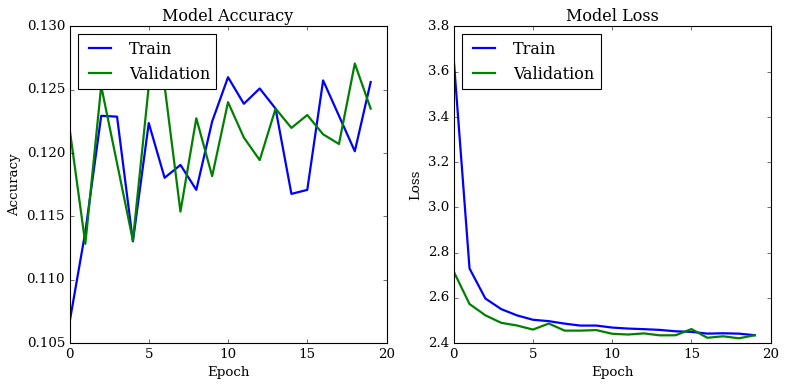

In [ ]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot training & validation accuracy
ax[0].plot(history.history['accuracy'], color='blue', lw=2)
ax[0].plot(history.history['val_accuracy'], color='green', lw=2)
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
ax[1].plot(history.history['loss'], color='blue', lw=2)
ax[1].plot(history.history['val_loss'], color='green', lw=2)
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


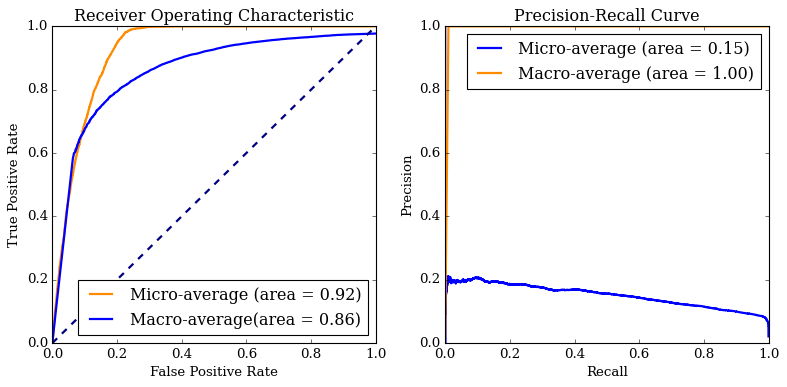

In [ ]:
# Get the predicted probabilities for the test set
y_pred_proba = model.predict(X_test)

# Binarize the output
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

# Initialize dictionaries for ROC curve data
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    if np.sum(y_test_binarized[:, i]) > 0:  # Check for positive samples
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba[:, :n_classes].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculate macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes) if i in fpr]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    if i in fpr:  # Only include classes with valid ROC data
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(fpr)  # Average over the number of classes with valid data
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Calculate micro-average precision and recall
precision_micro, recall_micro, _ = precision_recall_curve(y_test_binarized.ravel(), y_pred_proba[:, :n_classes].ravel())
average_precision_micro = auc(recall_micro, precision_micro)

# Calculate macro-average precision and recall
all_precisions = []
all_recalls = []

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    all_precisions.append(precision)
    all_recalls.append(recall)

# Interpolate the precision values for macro averaging
mean_recall = np.linspace(0, 1, 100)
mean_precision = np.zeros_like(mean_recall)

for i in range(len(all_precisions)):
    mean_precision += np.interp(mean_recall, all_recalls[i], all_precisions[i])

mean_precision /= len(all_precisions)  # Average over the number of classes
average_precision_macro = auc(mean_recall, mean_precision)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot ROC curve
ax[0].plot(fpr["micro"], tpr["micro"], label=f'Micro-average (area = {roc_auc["micro"]:.2f})', color='darkorange', lw=2)
ax[0].plot(fpr["macro"], tpr["macro"], label=f'Macro-average(area = {roc_auc["macro"]:.2f})', color='blue', lw=2)
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic')
ax[0].legend(loc='lower right')

# Plot Precision-Recall curve
ax[1].plot(recall_micro, precision_micro, label=f'Micro-average (area = {average_precision_micro:.2f})', color='blue', lw=2)
ax[1].plot(mean_recall, mean_precision, label=f'Macro-average (area = {average_precision_macro:.2f})', color='darkorange', lw=2)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Set document parameters
version = "small"
data_type = "train"

In [ ]:
# Load data from parquet files
def load_data(version, data_type, print_info=False):
    base_path = f"./data_processed/{version}_{data_type}_"
    files = ["behaviors_df_expanded.parquet", "history_df_expanded.parquet", "articles_df_expanded.parquet", "users_df_expanded.parquet"]
    dataframes = [pd.read_parquet(f"{base_path}{file}") for file in files]
    
    if print_info:
        for df in dataframes:
            print(df.info(), "\n")
    
    return dataframes

# Load data
behaviors_df, history_df, articles_df, users_df = load_data(version, data_type, print_info=False)

In [ ]:
# Merge dataframes
initial_row_count = behaviors_df.shape[0]
df = pd.merge(pd.merge(behaviors_df, articles_df, left_on='impression_article_id_inview', right_on='article_id', how='inner'), users_df, on='user_id', how='inner')
final_row_count = df.shape[0]
total_dropped_percentage = ((initial_row_count - final_row_count) / initial_row_count) * 100
print(f"Number of rows dropped due to merge: {(initial_row_count - final_row_count)} ({total_dropped_percentage:.2f}%)")

Number of rows dropped due to merge: 11 (0.00%)


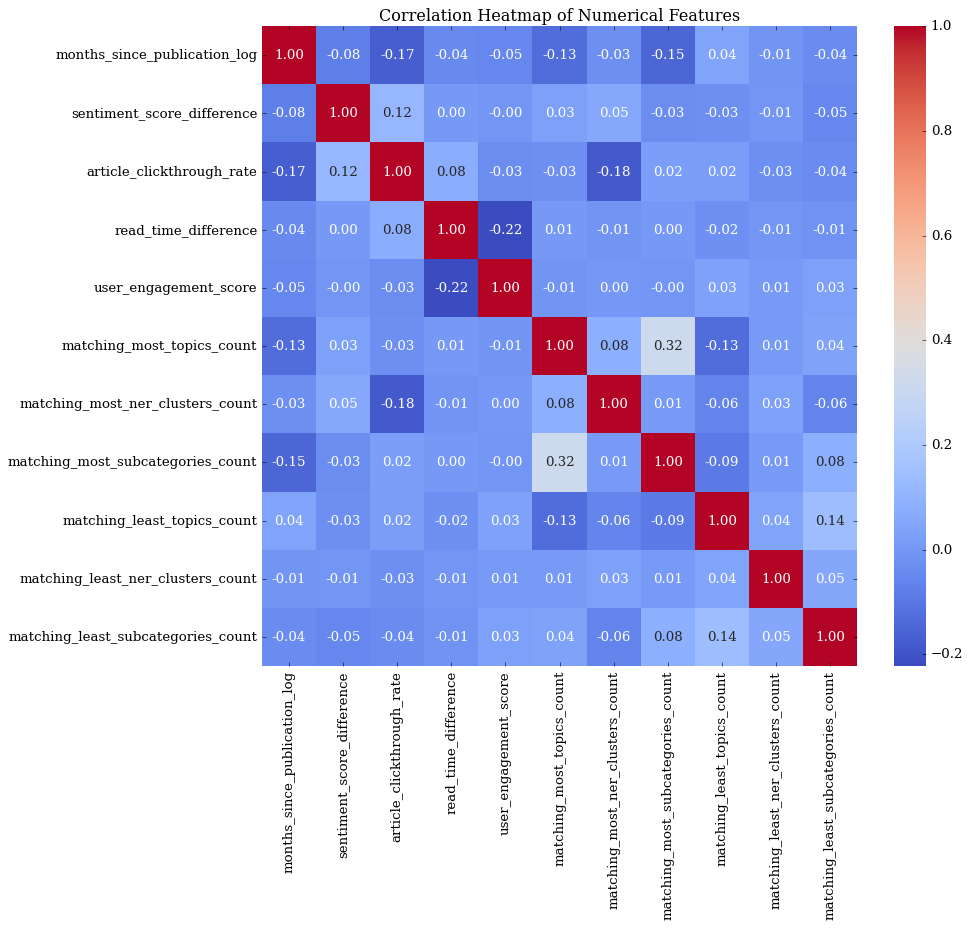

In [ ]:
# Feature engineering
df['months_since_publication'] = ((df['impression_time'].dt.year - df['article_published_time'].dt.year) * 12 + (df['impression_time'].dt.month - df['article_published_time'].dt.month))
df['months_since_publication_log'] = np.log1p(df['months_since_publication'])
df['sentiment_score_difference'] = df['article_sentiment_score'] - df['user_avg_sentiment_score']
df['article_clickthrough_rate'] = df['article_total_pageviews'] / df['article_total_inviews']
df['matching_most_topics_count'] = df.apply(lambda row: sum(topic in row['user_most_topics'] for topic in row['article_topics']), axis=1)
df['matching_most_ner_clusters_count'] = df.apply(lambda row: sum(cluster in row['user_most_ner_clusters'] for cluster in row['article_ner_clusters']), axis=1)
df['matching_most_subcategories_count'] = df.apply(lambda row: sum(subcat in row['user_most_subcategories'] for subcat in row['article_subcategory']), axis=1)
df['matching_least_topics_count'] = df.apply(lambda row: sum(topic in row['user_least_topics'] for topic in row['article_topics']), axis=1)
df['matching_least_ner_clusters_count'] = df.apply(lambda row: sum(cluster in row['user_least_ner_clusters'] for cluster in row['article_ner_clusters']), axis=1)
df['matching_least_subcategories_count'] = df.apply(lambda row: sum(subcat in row['user_least_subcategories'] for subcat in row['article_subcategory']), axis=1)
df['article_avg_read_time'] = df['article_total_read_time'] / df['article_total_inviews']
df['read_time_difference'] = df['article_avg_read_time'] - df['user_avg_read_time']
df['user_engagement_score'] = df['impression_read_time'] * df['impression_scroll_percentage'] * (df['impression_article_id_clicked'] + 1)
df['premium_article_premium_user'] = df.apply(lambda row: 0 if row['article_is_premium'] and not row['user_is_subscriber'] else 1, axis=1)

# Plot correlation heatmap
numerical_features = [
    'months_since_publication_log', 'sentiment_score_difference', 'article_clickthrough_rate', 'read_time_difference',
    'user_engagement_score', 'matching_most_topics_count', 'matching_most_ner_clusters_count', 'matching_most_subcategories_count',
    'matching_least_topics_count', 'matching_least_ner_clusters_count', 'matching_least_subcategories_count'
]
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [ ]:
# Drop rows with missing values
initial_nan_rows = df.isna().any(axis=1).sum()
df.dropna(inplace=True)
rows_dropped = initial_nan_rows
percentage_dropped = (rows_dropped / (df.shape[0] + rows_dropped)) * 100
print(f"Number of rows dropped due to missing values: {rows_dropped} ({percentage_dropped:.2f}%)")

Number of rows dropped due to missing values: 247490 (10.98%)


In [ ]:
# Define features and target
features = numerical_features + ['premium_article_premium_user']
target = 'target'

# Fix class imbalance
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(df[features], df[target])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), ['premium_article_premium_user'])
    ]
)

# Define the parameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

# Function to evaluate the model
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, df, features):
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities for the entire dataframe
    df['predicted_probability'] = pipeline.predict_proba(df[features])[:, 1]
    
    # Get the index of the maximum probability for each impression_id
    idx_max_prob = df.groupby('impression_id')['predicted_probability'].idxmax()
    
    # Get the predicted clicked articles
    predicted_clicks = df.loc[idx_max_prob, ['impression_id', 'impression_article_id_inview']]
    predicted_clicks = predicted_clicks.rename(columns={'impression_article_id_inview': 'predicted_clicked_article'})
    
    # Merge the predicted clicks with the original dataframe
    df = df.merge(predicted_clicks, on='impression_id', how='left')
    
    # Determine if the prediction was correct
    df['correct_prediction'] = df['predicted_clicked_article'] == df['impression_article_id_clicked']
    
    # Calculate evaluation metrics
    accuracy = df['correct_prediction'].mean()
    precision = precision_score(df[target], df['correct_prediction'], zero_division=0)
    recall = recall_score(df[target], df['correct_prediction'], zero_division=0)
    f1 = f1_score(df[target], df['correct_prediction'], zero_division=0)
    roc_auc = roc_auc_score(df[target], df['predicted_probability'])
    
    return accuracy, precision, recall, f1, roc_auc

# Perform grid search
best_score = 0
best_params = None
for C in param_grid['classifier__C']:
    for penalty in param_grid['classifier__penalty']:
        pipeline = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', C=C, penalty=penalty))
            ]
        )
        accuracy, precision, recall, f1, roc_auc = evaluate_model(pipeline, X_train, y_train, X_test, y_test, df, features)
        if roc_auc > best_score:
            best_score = roc_auc
            best_params = {'C': C, 'penalty': penalty}
        print(f"Parameters: C={C}, penalty={penalty} -> ROC AUC: {roc_auc:.4f}")

# Print best parameters and best score
print(f"Best parameters: {best_params}")
print(f"Best ROC AUC score: {best_score:.4f}\n")

# Use the best estimator to predict probabilities and evaluate
best_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', **best_params))
    ]
)
accuracy, precision, recall, f1, roc_auc = evaluate_model(best_pipeline, X_train, y_train, X_test, y_test, df, features)

# Cross-validation
cv_scores = cross_val_score(best_pipeline, X_resampled, y_resampled, cv=5, scoring='roc_auc')

# Calculate average number of articles per session
avg_articles_per_session = df.groupby('impression_id').size().mean()

# Print evaluation metrics and comparison with random guessing
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Cross-validated ROC AUC: {cv_scores.mean():.4f}\n')
print(f'Average number of articles per session: {avg_articles_per_session:.2f}')
print(f'Random guessing accuracy: {1 / avg_articles_per_session:.4f}')

Parameters: C=0.01, penalty=l1 -> ROC AUC: 0.6605
Parameters: C=0.01, penalty=l2 -> ROC AUC: 0.6606
Parameters: C=0.1, penalty=l1 -> ROC AUC: 0.6605
Parameters: C=0.1, penalty=l2 -> ROC AUC: 0.6605
Parameters: C=1, penalty=l1 -> ROC AUC: 0.6605
Parameters: C=1, penalty=l2 -> ROC AUC: 0.6605
Parameters: C=10, penalty=l1 -> ROC AUC: 0.6605
Parameters: C=10, penalty=l2 -> ROC AUC: 0.6605
Parameters: C=100, penalty=l1 -> ROC AUC: 0.6605
Parameters: C=100, penalty=l2 -> ROC AUC: 0.6605
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best ROC AUC score: 0.6606

Accuracy: 0.1626
Precision: 0.1367
Recall: 0.2204
F1 Score: 0.1688
ROC AUC: 0.6606
Cross-validated ROC AUC: 0.6504

Average number of articles per session: 9.78
Random guessing accuracy: 0.1023


```
Accuracy: 0.1626
Precision: 0.1367
Recall: 0.2204
F1 Score: 0.1688
ROC AUC: 0.6606
Cross-validated ROC AUC: 0.6504

Average number of articles per session: 9.78
Random guessing accuracy: 0.1023
```

(Results using `small` dataset)

**Explanation of Results**:

* **Accuracy** (16.26%): The model correctly predicts the clicked article 16.26% of the time, better than random guessing (10.23%).

* **Precision** (13.67%): When the model predicts an article as clicked, it is correct 13.67% of the time.

* **Recall** (22.04%): The model correctly identifies 22.04% of the actual clicked articles.

* **F1 Score** (16.88%): The balance between precision and recall is 16.88%.

* **ROC AUC** (66.06%): The model has a 66.06% chance of correctly distinguishing between clicked and non-clicked articles, better than random guessing (50%).

* **Cross-validated ROC AUC** (65.04%): Consistent performance across different data subsets.

* **Average Articles per Session** (9.78): On average, there are about 9.78 articles per session.

* **Random Guessing Accuracy** (10.23%): Randomly guessing the clicked article would be correct 10.23% of the time.

**Interpretation**:

The model's accuracy (16.26%) is better than random guessing (10.23%), indicating it learns patterns in the data.

The ROC AUC score (66.06%) shows the model is better than random at distinguishing clicked articles.

Precision, recall, and F1 scores are low, suggesting room for improvement through better features, more complex models, hyperparameter tuning, and data augmentation.

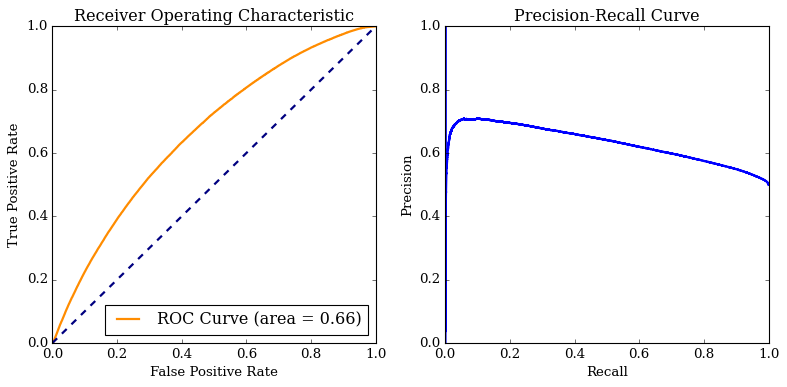

In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, best_pipeline.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, best_pipeline.predict_proba(X_test)[:, 1])

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot ROC curve
ax[0].plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})', color='darkorange', lw=2)
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic')
ax[0].legend(loc='lower right')

# Plot Precision-Recall curve
ax[1].plot(recall, precision, color='blue', lw=2)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])

# Adjust layout
plt.tight_layout()
plt.show()